# Поиск закономерностей в развитии компьютерных игр

**Цель исследования** - выявить определяющие успешность игры закономерности для прогноза развитие продуктов в следующем году.

**Описание данных**  - исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

<div align='right'>Проектную работу выполнил студент Гагиев Денис. </div>

---

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# загрузка данных
data = pd.read_csv('ссылка скрыта')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Из первого наблюдения видны:**
* некорректные названия столбцов;
* пропуски в некоторых столбцах;
* формат данных, например, год релиза игры указан в дробном значении.

---

## Предобработка данных 

### Переименование столбцов 

In [3]:
# нижний регистр
data.columns = data.columns.str.lower()

### Работа с пропусками

In [4]:
# удаление 2-х игр без названия и жанра и удаление пропуской с годом выпуска игры 
data = data.dropna(subset=['name', 'year_of_release'])

# замена пропусков в столбцах с рейтингом - ЛУЧШЕ НЕ ЗАПОЛНЯТЬ ОЦЕНКИ ПОЛЬЗОВАТЕЛЕЙ И КРИТИКОВ
data['rating'] = data['rating'].fillna('unknow')

# меняем не определенный рейтинг tbd на пропуск
data['user_score'] = data['user_score'].where(data['user_score'] != 'tbd', np.nan)

**Логика заполнения пропусков** - не критично удалить 2 игры без названия и жанра. Не решился заполнять пропуски с рейтингом значениями исходя из взаимосвязи данных, поскольку это может негативно повлиять на дальнейший ход ислледования. Оценки пользователей и критиов лучше не заполнять.

**'tbd' в рейтинге** - "To Be Determined" - "будет определенно" такое значение появляется, когда для формирования рейтинга не хватает данных. Например, в играх у игрока вместо рейтинга может быть такое значение, что говорит о том, что игрок не провел достаточное колличество игр для формирования его рейтинга. 

**Возможные причина пропусков** - 2 игры просто забыты этим миром. Год выпуска - может быть техническая ошибка или не корректный сбор данных, поскольку не все источники имеют год релиза игры. Не всегда к играм проводится оценка по рейтингу, это может быть причиной пропусков в столбцах, связанных с рейтингом в том числе возрастным. 

### Работа с типами данных

In [5]:
# замена типов данных в столбце с годом релиза игры 
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y')
data['year_of_release'] = pd.DatetimeIndex(data['year_of_release']).year

# убираем не нужные дробные значения в столбце 'critic_score'
data['critic_score'] = data['critic_score'].astype('Int64')

# столбец user_score
data['user_score'] = data['user_score'].astype('float')

При изменении формата данных в столбцах с рейтингом была мысль округлить значения и изменить формат данных на int, передумал поскольку посчитал, что эо может повлить на точность исследования.  

### Подсчет суммарных продаж

In [6]:
# добавим столбец с суммой продаж
data['sum_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

---

## Иследовательский анализ данных

### Выпуск игр по годам

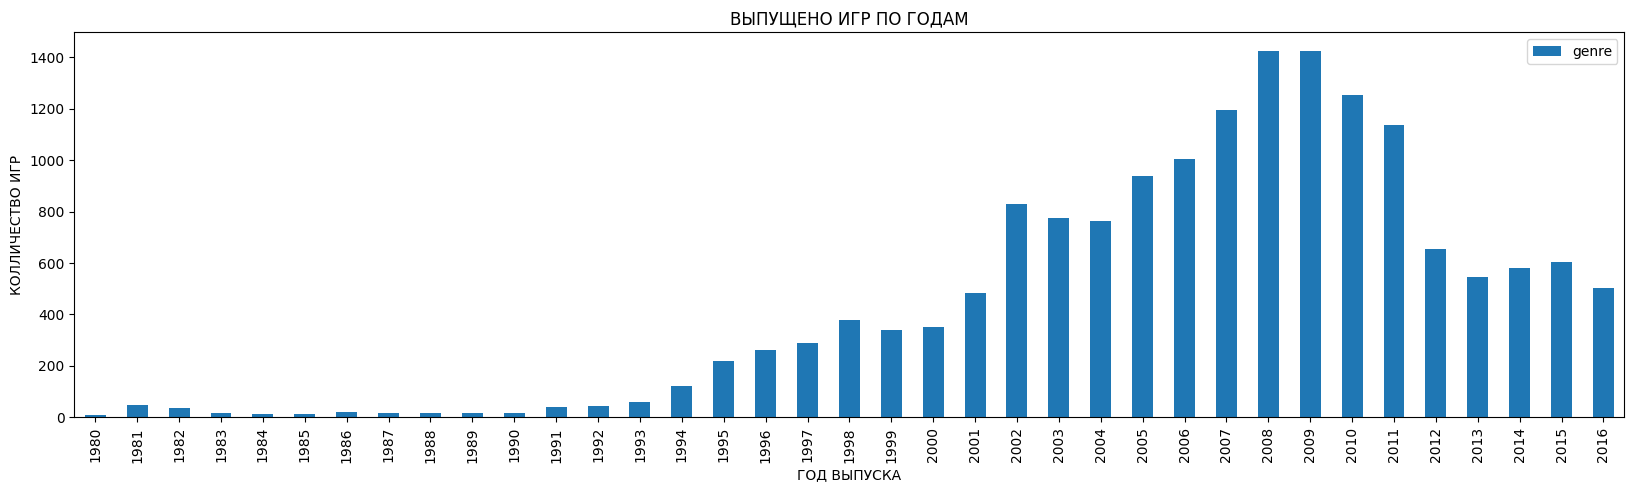

In [7]:
(data
    .pivot_table(index='year_of_release', values='genre', aggfunc='count')
    .plot(kind='bar', figsize=(20,5), title='ВЫПУЩЕНО ИГР ПО ГОДАМ',
         ylabel='КОЛЛИЧЕСТВО ИГР', xlabel='ГОД ВЫПУСКА')
)
plt.show()

**Комментарий.** Видна четкая временная тенденция развития игровой индустрии. Особое активное развитие видно с 1993 года. Пик выпущенных игр за год пришелся на 2009 год. Далее колличество выпущеных игр имеет нисходящий тренд, к 2016 году видим наименьшее колличество выпущенных игр, возможно это связанно с усложняющейся экономической ситуацией в ряде стран.

Возможно данные до 1990 года не имеют особой важности. 

### Продажи по платформам с ходом времени

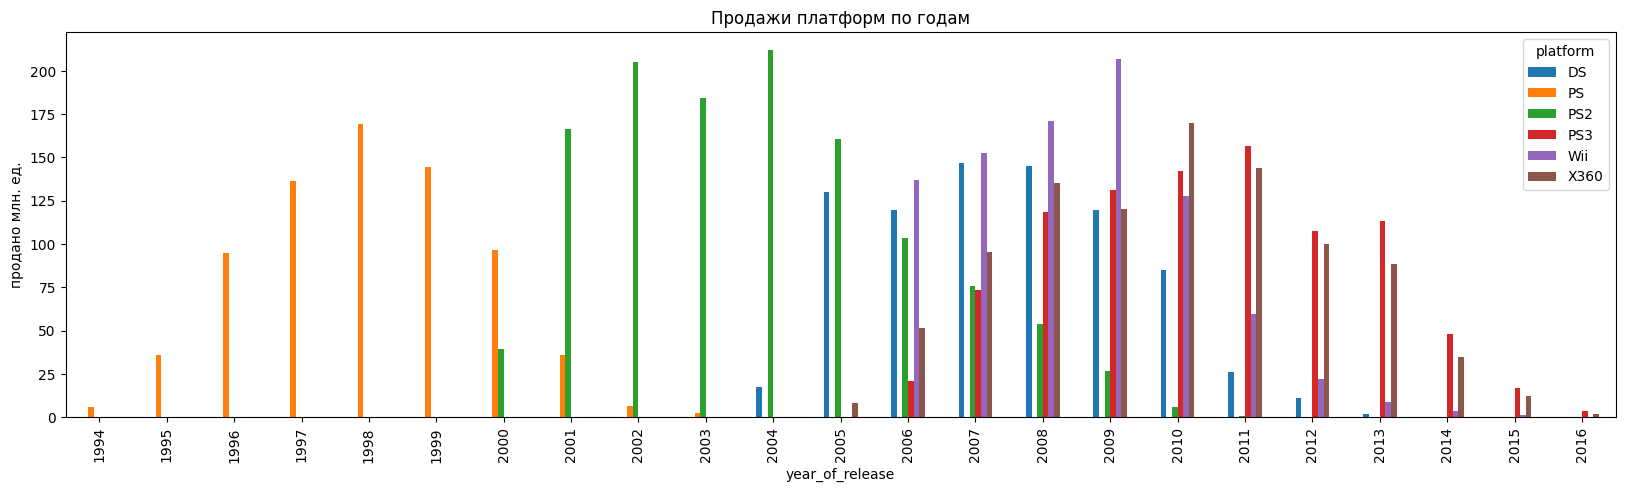

In [8]:
# смотрим самые популярные платформы
(data
    .pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
)

# создаем отфильтрофанный дф с только популярными платформами
data_fil = data.loc[data['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']) & (data['year_of_release'] > 1993)]

# построение графика
(data_fil
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(kind='bar', figsize=(20,5), title='Продажи платформ по годам', ylabel='продано млн. ед.')
)
plt.show()

**Комментарий.** Можем наблюдать "эпохи" популярных игровых платформ. Так, например, видно, что начиная с 94-го года отличные показатели по продажам игр занимает платформа PS. В 2000-м на её смену постепенно приходит следующая серия PS2, как и в 2006-м смещает вторую серию уже третья серия PS3. Одновременно с этим, начиная с 2004-го года хорошие показатели по прадажам показываем платформа DS. Фаворитом по колличеству продаж игр за год является платформа Wii, на которую в 2009-м году продали более 200млн.ед. игр.

В среднем каждая из платформ в менее и более актуальной степени существует по 9 лет. В тоже время примерно, на момент через 5-6 лет после выхода одной платформы, появляется следующуя, если говорить про серию PS. 

### Лидеры среди игровых платформ

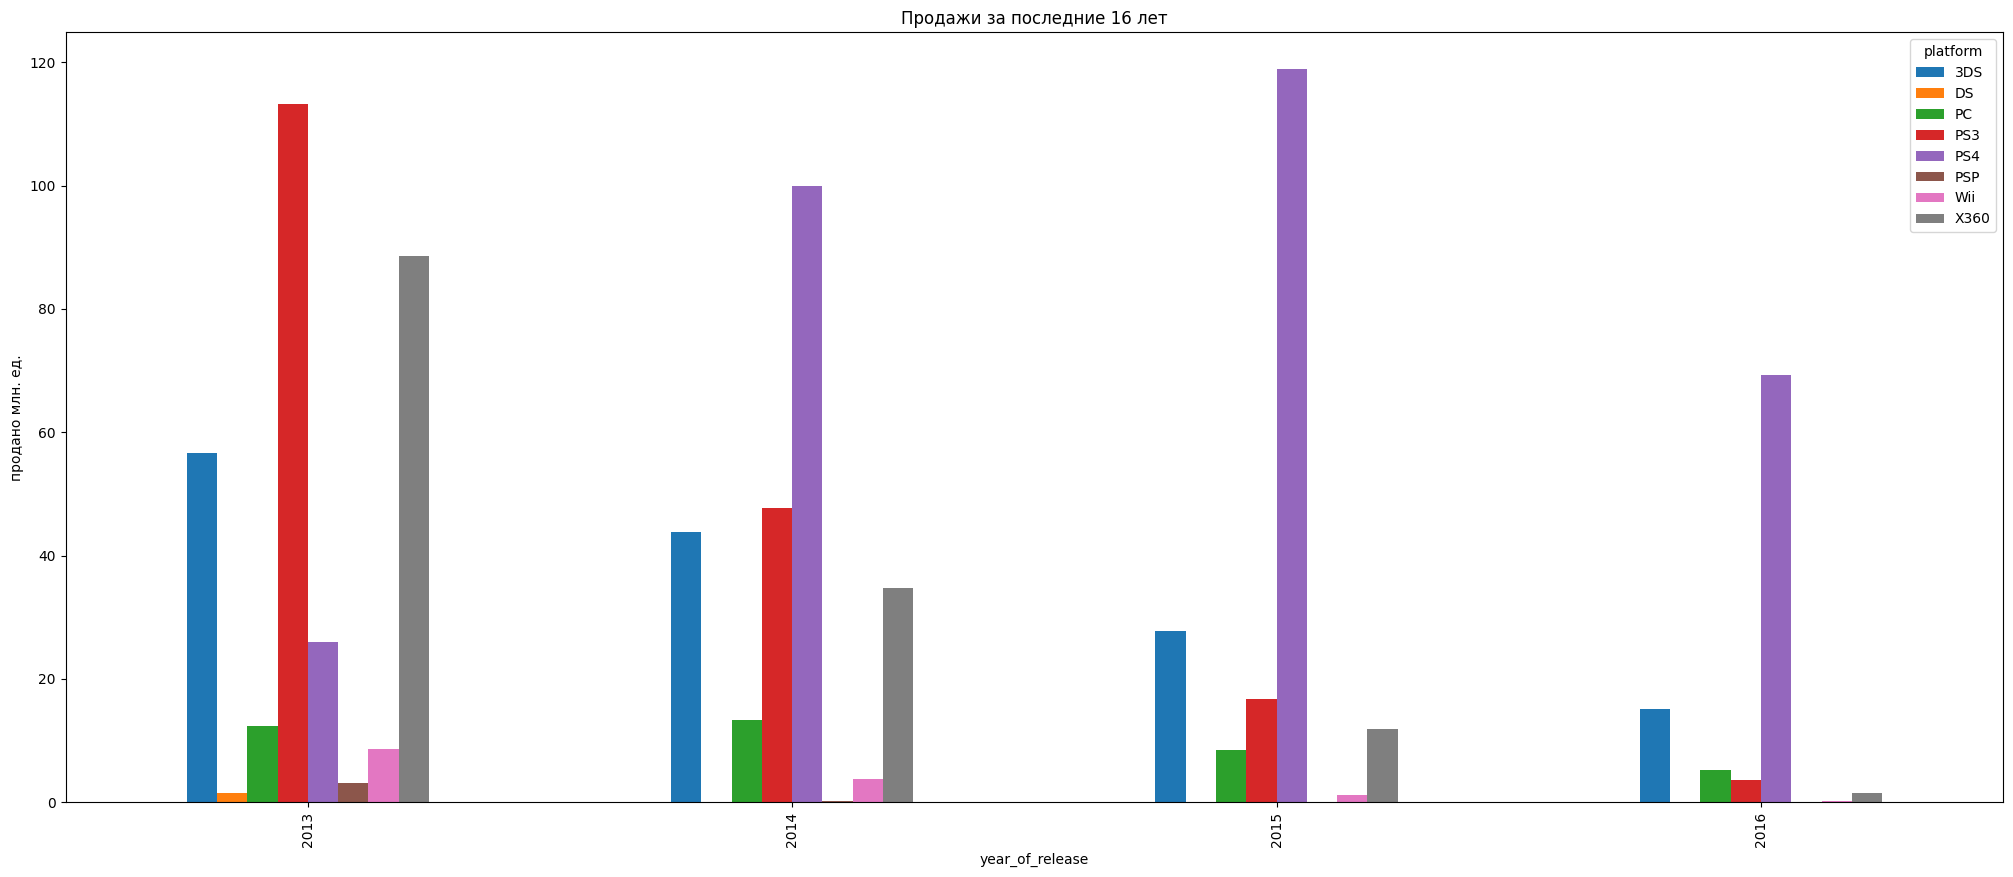

In [9]:
# берем данные начиная с 2000 года 
data_two = data.loc[data['year_of_release'] >= 2013]

# изучаем более обширный список актуальных платформ за последние 16 лет 
pivot_df = (data_two
    .pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
    .reset_index() 
)

# снова фильтруем data_two, но уже по платформам
data_two = (
    data_two.loc[
        (data_two['platform'] == 'PS2') | (data_two['platform'] == 'PS4') |
        (data_two['platform'] == 'X360') | (data_two['platform'] == 'PSP') |
        (data_two['platform'] == 'PS3') | (data_two['platform'] == '3DS') |
        (data_two['platform'] == 'Wii') | (data_two['platform'] == 'XB') |
        (data_two['platform'] == 'DS') | (data_two['platform'] == 'PC') |
        (data_two['platform'] == 'GBA')]
)

# возьмем первые 14 платформ - построение графика
(data_two
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(kind='bar', figsize=(25,10), title='Продажи за последние 16 лет', ylabel='продано млн. ед.')  
)
plt.show()

**Комментарий.** В первую очередь стоит отметить стабильность PC, относительно уходящих и приходящих платформ. На PC продают достаточно много игр из года в год, обусловленно это конечно же тем, что консоли нельзя модернизировать технически и они имеют ограниченный срок актуальности. 

Платформы серии PS показывают следующую картину: PS3 имеет очень хорошие показатели по продажам в течении многихлет, ее младший брат PS4 имеет примерной такой же путь по объему продаж, не исключенно, что консоль будет оставаться актуальной и до 3-го дясителетия. 

Виден закат Wii, на момент 2016 года игры на данную платформу уже практически не продаются, компании выпускающую данную консоль важно дать второе дыхания их консолям и выпустить новый и конкурирующий продукт, опираясь на свой достаточно успешный опыт.  

Игры на X360 также очень востребованы ны рынке. Сейчас на момент 2016 года компании нужно взять пример со своего конкурента Sony и продолжать выпускать более конкурентоспособный продукт. 

Низкие объемы продаж платформы PSP в актуальный период времени. Также заходящая эпоха DS.

**P.S.** Но для дальнейшего анализа данных считаю необходимо еще сильнее снизить круг рассматриваемых платформ. Исходя из цели анализа по разработке рекомендаций потенциально новому продукту считают необходимым оставить: PC (поскольку нет платформы более стабильной), актуальную на данный момент PS4, из ручных консолей взять только последню по временному графику 3DS, также взять платформу X360 и нашумевшую Wii (как минимум, чтобы изучить опыт их звездного времени).

**P.S.S.** А также снизить рассматриваемое время до 2010 года.

### Ящики с усами продаж наиболее актуальных платформ

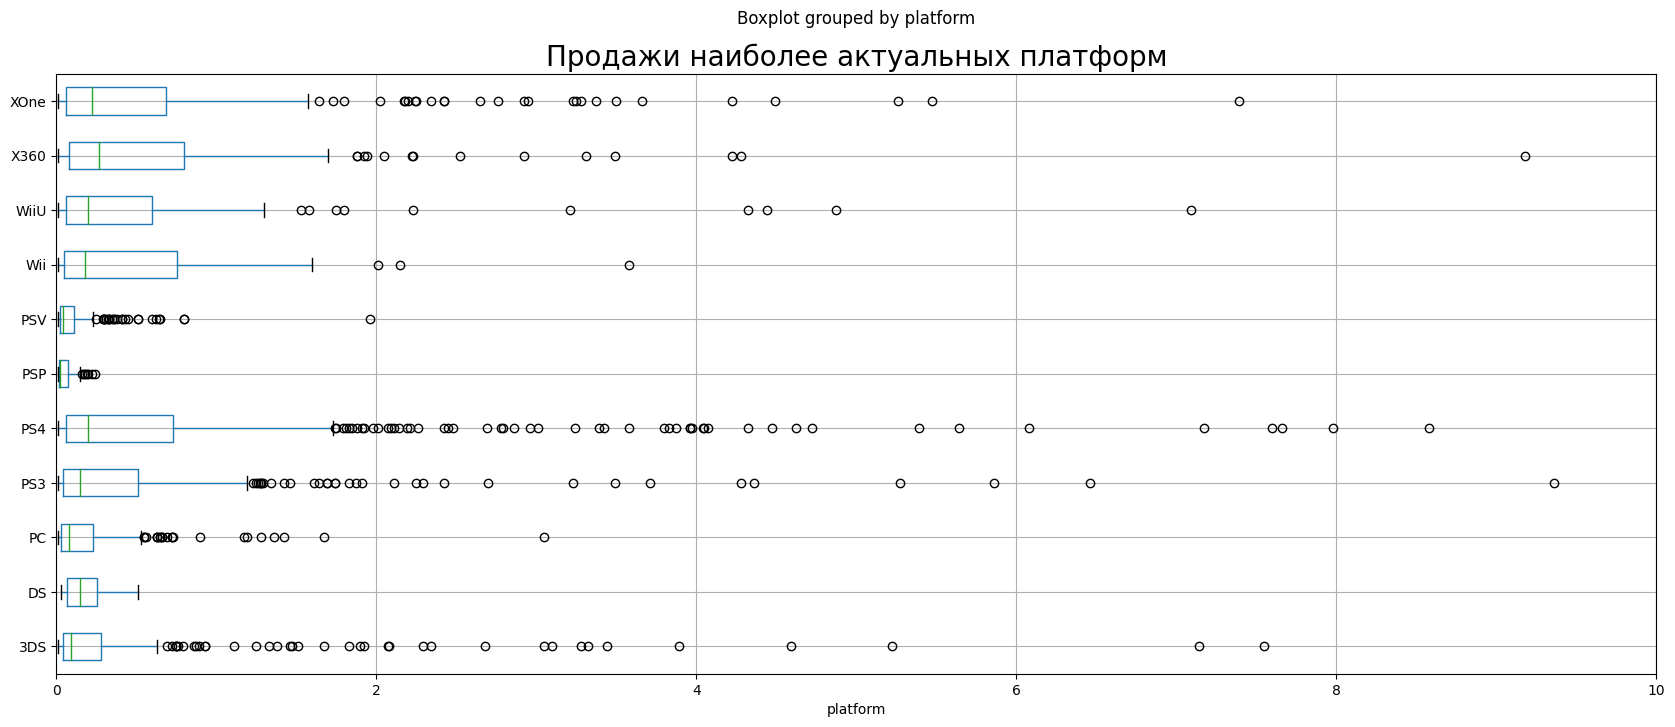

In [10]:
# обратите внимание! Переменная снизу будет использоваться в последующих заданиях. 
data_filter = data.query('year_of_release >= 2013')

data_filter.boxplot(by='platform',  column='sum_sales', figsize=(20,8), vert=False)
plt.xlim(0,10)
plt.title('Продажи наиболее актуальных платформ', fontsize=20)
plt.show()

 **Комментарий.** Среди актуальных платформ за последнее время сразу же видно 2 фаворита - это всеми известная платформа PS4 и X360. В рамках показателя медианы игры на PS4 покупают по 80 млн.ед. в год, в тоже время X360 покупают примерно 60млн. ед в год. Важно заметить, что разбор показателей у X360 значитель больше, нежели у PS4, что говорит о более статичном интересе геймеров к PS4. 

Также очень неплохие показатели продаж у платформы XOne, видно множество выбросов данных, что скорее всего говорит об множестве удачных игр с выделяющимися продажами. 
 
Показатели по продажам игр на PC значительно не отличаются от всех остальных лет, но опять же, этот показатель данная платформа имеет из года в год. 

Очень неплохие показатели по продажам имеет платформа 3DS, в среднем игры на данную платформу покупают в размере 50млн.ед. в год. Что подтверждает - опыт данной платформы можно задействовать при формировании рекомендаций для нового продукта.


Наименьшие усредненные показатели среди фаворитов  по продажам имеет платформа Wii, объясняется тем, что на данном графике мы не затрагиваем "звездные годы" данной платформы. То есть в последнее время платформа уже не имеет столь высокий уровень актуальности.

Таким образом среди каждой компании-производителя наблюдаются свои фаворитные платформны, как PS4, X360 и Wii.

### Оценка влияния критики пользователей на продажи игр для PS4

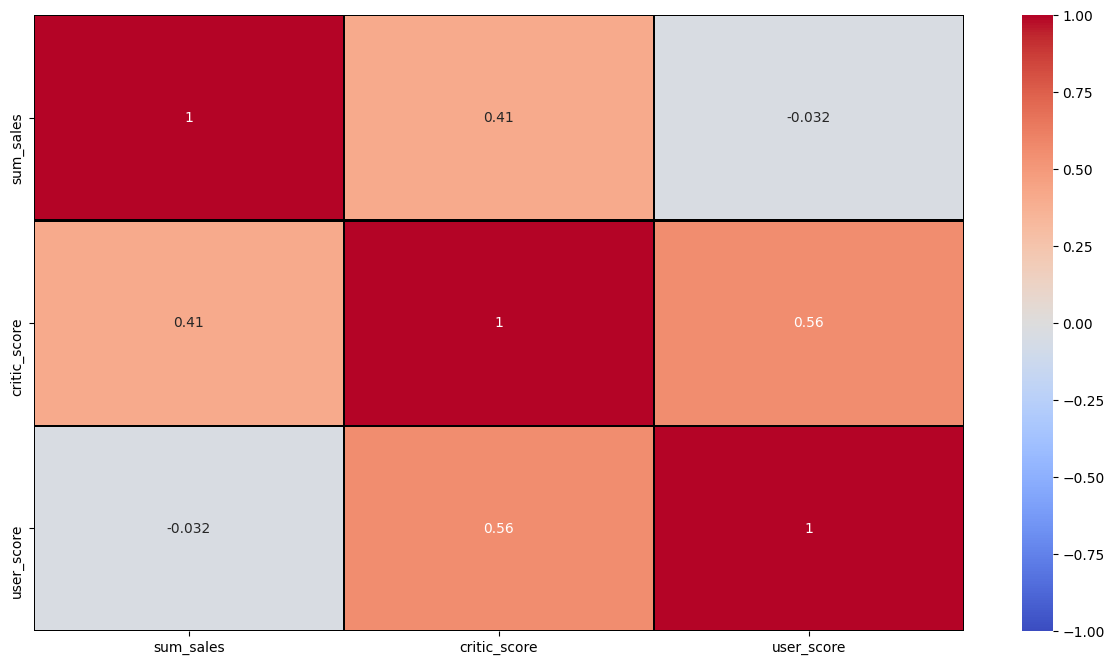

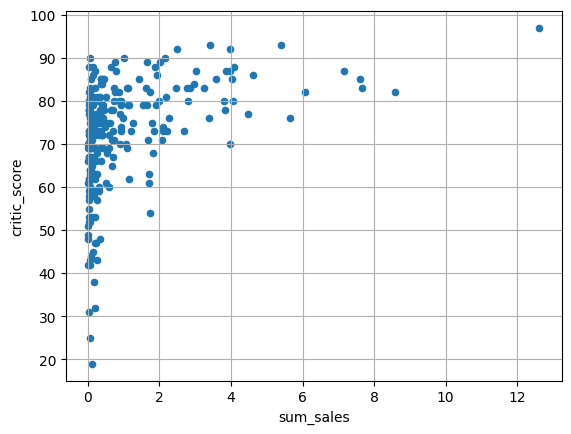

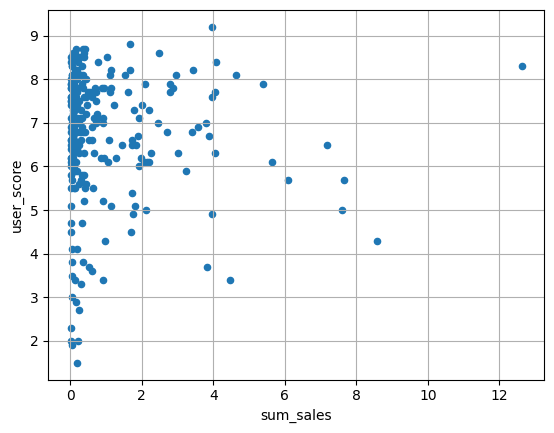

In [11]:
# фильтруем датасет
psfour_only = data_filter.query('platform == "PS4"')
psfour_only = psfour_only[['sum_sales', 'critic_score', 'user_score']]

#построение тепловый карты с корреляцией
plt.figure(figsize=(15,8))
sns.heatmap(
    psfour_only.corr(), annot=True, 
    vmin=-1, vmax=1, center=0, cmap='coolwarm', #мин. макс. цент цвет. и цветовая палитра cbar=False - убрать шкалу
    linewidths=1, linecolor='black' #толщина и цвет линии между ячейками
)
plt.show()

# диаграммы рассеяния
psfour_only.plot(kind='scatter', x='sum_sales', y='critic_score', grid=True)
psfour_only.plot(kind='scatter', x='sum_sales', y='user_score', grid=True)
plt.show()

**Комментарий.** Положительная зависимость между продажи и оценкой критиков и пользователей есть и она положительная, что говорит о том, что при увеличении оценки - есть вероятность роста продаж. На диаграммах рассеяния так же видна зависимость продаж от оценки, с ростом оценки растут продажи.

### Зависимость продаж от оценок для иных платформ 

Тепловая карта и диграмма рассеяния зависимости оценки от продаж для PC


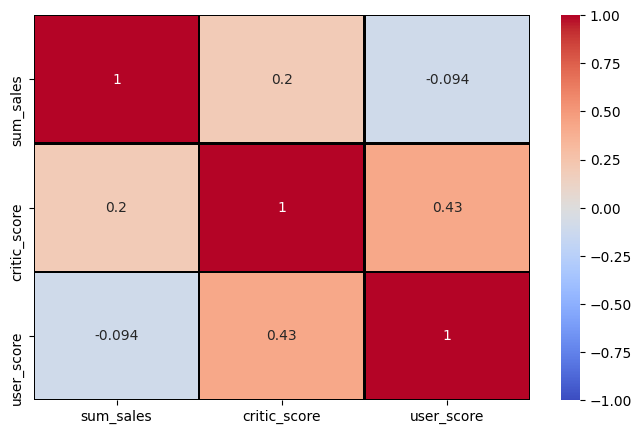

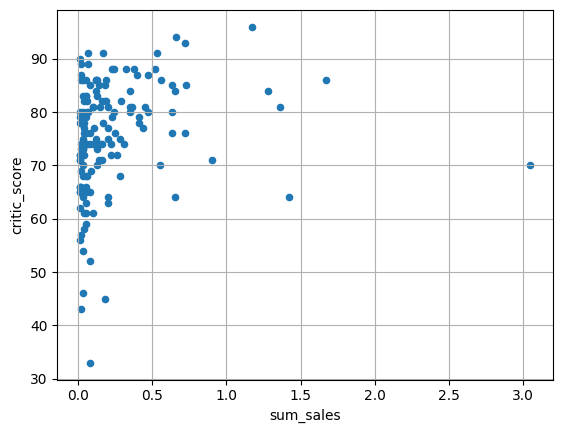

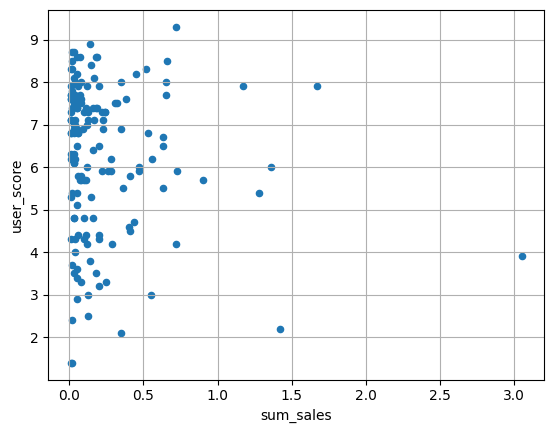

Тепловая карта и диграмма рассеяния зависимости оценки от продаж для 3DS


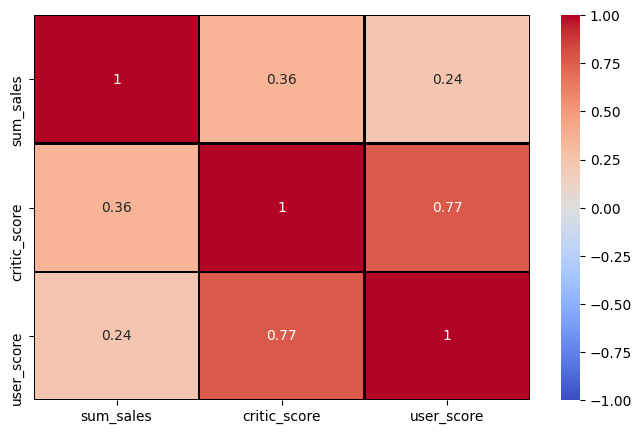

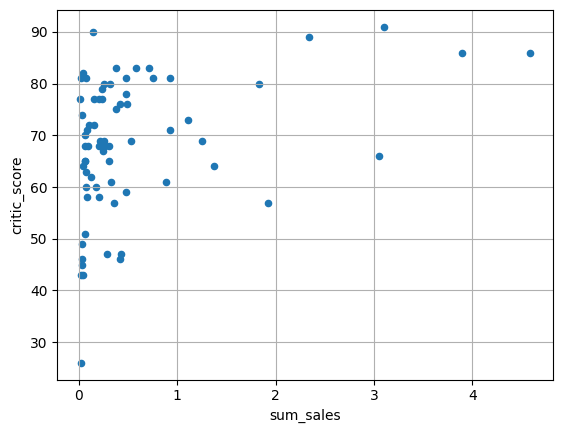

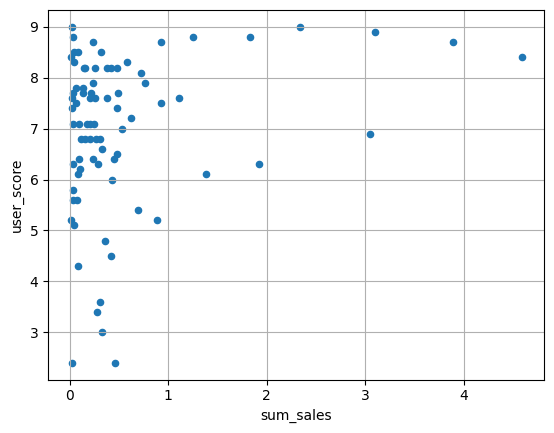

Тепловая карта и диграмма рассеяния зависимости оценки от продаж для X360


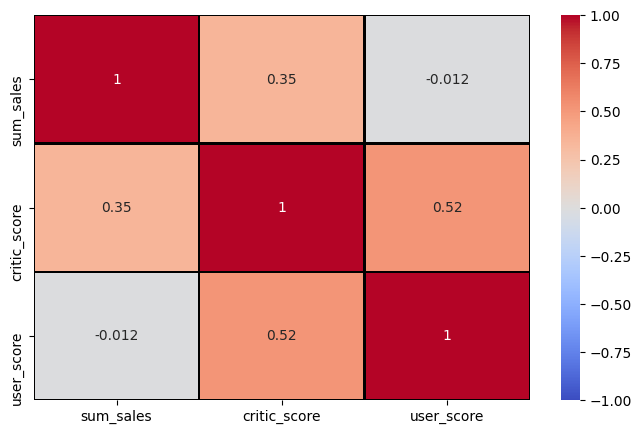

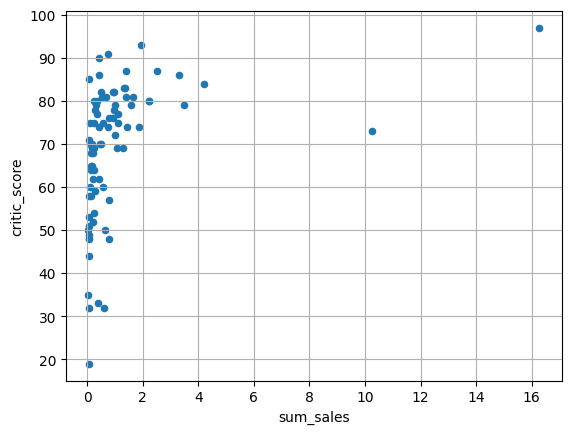

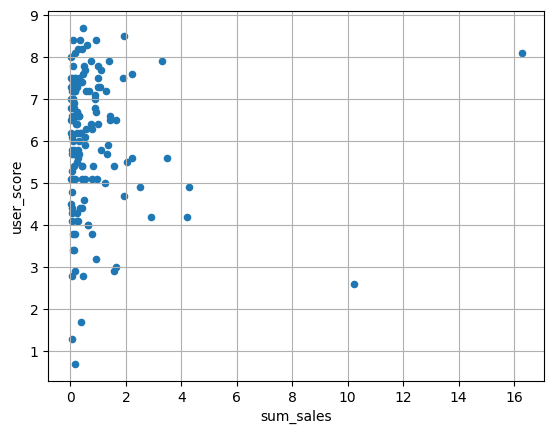

In [12]:
for platforma in ['PC', '3DS', 'X360']:   
    time_df = data_filter.loc[data_filter['platform'] == platforma]
    
    print('Тепловая карта и диграмма рассеяния зависимости оценки от продаж для', platforma)
    
    plt.figure(figsize=(8,5))
    sns.heatmap(time_df[['sum_sales', 'critic_score', 'user_score']].corr(), annot=True, 
    vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=1, linecolor='black')
    plt.show()

    time_df.plot(kind='scatter', x='sum_sales', y='critic_score', grid=True)
    time_df.plot(kind='scatter', x='sum_sales', y='user_score', grid=True)
    plt.show()

**Комментарий.** Чуть меньшая зависимость оценки критиков по отношению к продажам имеется у платформы PC (0.3), практически нет никакой зависимости продаж от оценок пользователей, что достаточно странно.. Платформа 3DS имеет положительную зависимость оценки критиков и пользователей 0.36 и 0.2. Практически такая же корреляция у платформы X360 оценки критиков и продаж - 0.36, но в тоже время незначительно отрицательная от оценки пользователей и продаж

Таким образом, можно предположить, что оценки критиков имеют куда большее значение на продажи, нежели оценки пользователей. А у некоторых платформ, таких как PC и X360 такой вообще не наблюдается зависимость оценки пользователей и продаж.



### Анализ жанров игр 

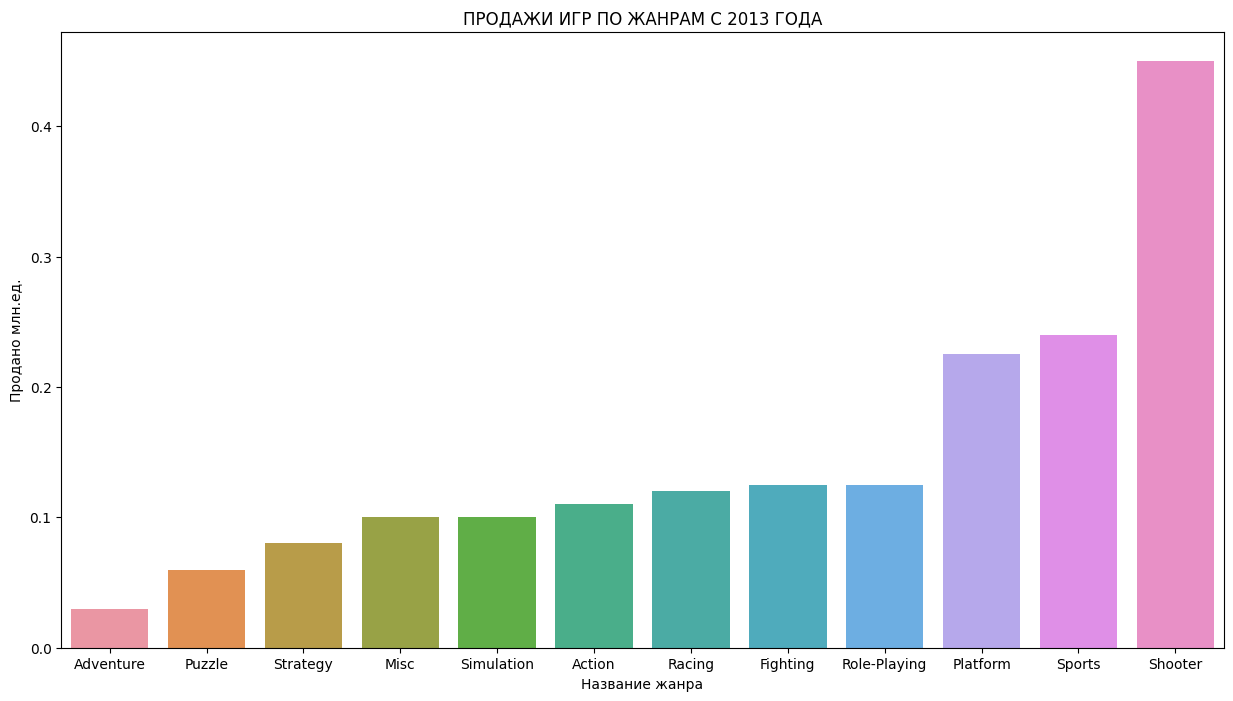

In [13]:
# формирование даннных под график
for_beati_bar = (data.query('year_of_release >= 2013')
    .pivot_table(index='genre', values='sum_sales', aggfunc='median')
    .sort_values(by='sum_sales')
)
for_beati_bar = for_beati_bar.reset_index()

# построение графика
plt.figure(figsize=(15,8))
ax = sns.barplot(x='genre',
            y='sum_sales',
            data=for_beati_bar)
ax.set_title('ПРОДАЖИ ИГР ПО ЖАНРАМ С 2013 ГОДА')
ax.set(xlabel='Название жанра', ylabel='Продано млн.ед.')
plt.show()

**Комментарий.** Первое место по популярности занимают Шутеры. Не сильно отстают спортивные игры. Тройку фаворитов примерно на одном уровне замыкают Платформеры и Бои. Это что касается жанров, которые выделяются по высоким продажам. 

Четко видно отличие по колличеству продаж у менее распостраненных жанров, таких, как Стратегии, Приключения и Пазлы. 

---

## Портреты пользователей по регионам

### Топ платформ по продажам в разных регионах

In [14]:
# создаем список с именами регионов
regions = ['NA_sales', 'EU_sales', 'JP_sales']

# создаем цикл на построение продаж по платформам для каждого региона
for region in regions:
    print('Топ платформ в', region)
    
    # подготовливаем данные  
    dat = (data.query('year_of_release >= 2013')
            .pivot_table(index='platform', values=region, aggfunc='sum')
            .sort_values(by=region, ascending=False).reset_index())
    
    # строим график
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='platform', y=region, data=dat.head())
    ax.set(xlabel='Название платформы', ylabel='Продано млн.ед.')
    plt.show()
    
    print()

Топ платформ в NA_sales


KeyError: 'NA_sales'

**Комментарий** В Северной Америке любимая платформа геймеров - это PS4. Также распостранены XOne и X360.

В Европе тоже больше всего любят PS4, даже больше чем в Америке, поскольку второе место у них занимает PS3. XOne и X360 - 3-е и 4-е место. 

Япония всегда выделялась, так и здесь самая распостраненная платформа ручная Nintendo 3DS, удивительно, что PS4 занимает предпоследнее 4-е место.

### Топ жанров по продажам в разных регионах

In [ ]:
# создаем цикл на построение продаж по жанрам для каждого региона
for region in regions:
    print('Топ жанров в', region)
    # подготовливаем данные  
    dat = (data.query('year_of_release >= 2013')
            .pivot_table(index='genre', values=region, aggfunc='median')
            .sort_values(by=region).reset_index().tail())
    # строим график
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='genre', y=region, data=dat)
    ax.set(xlabel='Название жанра', ylabel='Продано млн.ед.')
    plt.show()
    print()

**Комментарий.** Видимо менталитет жителей Северной Америки и Европы не сильно отличается относительно игровых предпочтений, обе выборки в первую очередь любят Шутеры, чуть меньше платформеры, а также Спортивные игры. 

А вот Японцы больше всего любят Ролевые игры) Чуть меньше Японцам нравится Бои, а вот к Шутерам Японцы достаточно нейтральны, им больше нравится Пазлы и Музыкальные игры.

### Влияние рейтинга ESBR на продажи

In [ ]:
# создаем цикл на построение продаж по жанрам для каждого региона
for region in regions:
    print('Топ рейтинг в', region)
    # подготовливаем данные  
    dat = (data.query('year_of_release > 2010')
            .pivot_table(index='rating', values=region, aggfunc='sum')
            .sort_values(by=region).reset_index())
    # строим график
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='rating', y=region, data=dat)
    ax.set(xlabel='Возрастной рейтинг ', ylabel='Продано млн.ед.')
    plt.show()
    print()

**Комментарий.** И действительно, самые классные и распостраненные игры категории А (17+). Много игр покупают и меньше возрастной категории Е (7+ лет). В графике региона Япония виден артифакт, у них самый распостраненная категория unknow, это может быть 2-м причинам: 1) в Японии не работает данная система рейтинга; 2) ошибки при загрузке и сборе данных, которые и привели к подобным пропускам. 

**Общий комментарий**

Можно попытаться представить 3 самых распространенных портрета пользователей из каждого региона.

- **Северная Америка** - это старше 17-ти лет человек, любящий Экшен игры и, скорее всего, владеющий Xbox 360;
- **Европа** - игрок также старше 17-ти лет, любит Экшен игры, но, скорее всего, предпочитает платформы от компании Sony;
- **Япония** -  к сожалению, в связи с проблемами данных слишком рискованно говорить об возрасте, но Японский Геймер любит Ролевые игры и, как правило, является владельцем 3DS.  

---

### Топ платформ по продажам в разных регионах

<div class="alert alert-block alert-danger">
<b>❌Комментарий ревьюера:</b> 
    
Напомню, что определять портреты пользователей в регионах нам нужно по данным из актуального периода. 

Учитывая высокую динамичность рынка, мы можем сделать вывод, что для анализа нам потребуются данные по платформам, возникшим не ранее 3 лет назад по отношению к 2017 году, на который нам нужно сделать прогноз и запланировать рекламные кампании. Так мы сможем выделить успешные платформы, которые на 2017 год будут находиться в периоде финального роста или выйдут на плато.</div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
Поправил.
</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

In [ ]:
# создаем список с именами регионов
regions = ['NA_sales', 'EU_sales', 'JP_sales']

# создаем цикл на построение продаж по платформам для каждого региона
for region in regions:
    print('Топ платформ в', region)
    
    # подготовливаем данные  
    dat = (data.query('year_of_release >= 2013')
            .pivot_table(index='platform', values=region, aggfunc='sum')
            .sort_values(by=region, ascending=False).reset_index())
    
    # строим график
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='platform', y=region, data=dat.head())
    ax.set(xlabel='Название платформы', ylabel='Продано млн.ед.')
    plt.show()
    
    print()

**Комментарий** В Северной Америке любимая платформа геймеров - это PS4. Также распостранены XOne и X360.

В Европе тоже больше всего любят PS4, даже больше чем в Америке, поскольку второе место у них занимает PS3. XOne и X360 - 3-е и 4-е место. 

Япония всегда выделялась, так и здесь самая распостраненная платформа ручная Nintendo 3DS, удивительно, что PS4 занимает предпоследнее 4-е место.

<div class="alert alert-block alert-warning">
<b>🔁Комментарий ревьюера:</b>

Здорово ,что используешь циклы! Но результаты получились не совсем верные из-за слишком большого актуального периода</div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
Исправил вывод по новому графику.
</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

### Топ жанров по продажам в разных регионах

In [ ]:
# создаем цикл на построение продаж по жанрам для каждого региона
for region in regions:
    print('Топ жанров в', region)
    # подготовливаем данные  
    dat = (data.query('year_of_release >= 2013')
            .pivot_table(index='genre', values=region, aggfunc='median')
            .sort_values(by=region).reset_index().tail())
    # строим график
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='genre', y=region, data=dat)
    ax.set(xlabel='Название жанра', ylabel='Продано млн.ед.')
    plt.show()
    print()

<div class="alert alert-block alert-danger">
<b>❌Комментарий ревьюера:</b> 
    
Нам интересны только топ-5 жанров в каждом регионе)</div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
Исправил. Также исправил код относительно предыдущих исправлений, теперь Шутер самый любимый жанр. Исправил комментарий.
</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍  </div>

**Комментарий.** Видимо менталитет жителей Северной Америки и Европы не сильно отличается относительно игровых предпочтений, обе выборки в первую очередь любят Шутеры, чуть меньше платформеры, а также Спортивные игры. 

А вот Японцы больше всего любят Ролевые игры) Чуть меньше Японцам нравится Бои, а вот к Шутерам Японцы достаточно нейтральны, им больше нравится Пазлы и Музыкальные игры.

### Влияние рейтинга ESBR на продажи

In [ ]:
# создаем цикл на построение продаж по жанрам для каждого региона
for region in regions:
    print('Топ рейтинг в', region)
    # подготовливаем данные  
    dat = (data.query('year_of_release > 2010')
            .pivot_table(index='rating', values=region, aggfunc='sum')
            .sort_values(by=region).reset_index())
    # строим график
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='rating', y=region, data=dat)
    ax.set(xlabel='Возрастной рейтинг ', ylabel='Продано млн.ед.')
    plt.show()
    print()

**Комментарий.** И действительно, самые классные и распостраненные игры категории А (17+). Много игр покупают и меньше возрастной категории Е (7+ лет). В графике региона Япония виден артифакт, у них самый распостраненная категория unknow, это может быть 2-м причинам: 1) в Японии не работает данная система рейтинга; 2) ошибки при загрузке и сборе данных, которые и привели к подобным пропускам. 

<div class="alert alert-block alert-warning">
<b>🔁Комментарий ревьюера:</b>

Про Японию ты абсолютно верно подметил!
    
А как ты все-таки думаешь, почему в Японии большинство игр не имеют рейтинга ESRB? В поисковых системах быстро найдется ответ (ты уже сделал верное предположение)</div>

<div class="alert alert-block alert-info">
<b>🔄Комментарий студента:</b> 
В Японии робает немного иная система CERO. Но в тоже время и в Европе работает иная система PEGI, поэтому даже затрудняюсь с ответом...
</div>

<div class="alert alert-block alert-success">
<b>✅Комментарий ревьюера 2:</b> Отлично, исправлено!👍 Ты же ответил на поставленный вопрос) </div>

**Общий комментарий**

Можно попытаться представить 3 самых распространенных портрета пользователей из каждого региона.

- **Северная Америка** - это старше 17-ти лет человек, любящий Экшен игры и, скорее всего, владеющий Xbox 360;
- **Европа** - игрок также старше 17-ти лет, любит Экшен игры, но, скорее всего, предпочитает платформы от компании Sony;
- **Япония** -  к сожалению, в связи с проблемами данных слишком рискованно говорить об возрасте, но Японский Геймер любит Ролевые игры и, как правило, является владельцем 3DS.  

---

## Проверка гипотез

**Далее будут проверены 2 гипотезы:**
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Значение alpha будет задано 0.5**


### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: Пользовательский рейтинг (user_score) платформы Xbox One = Пользовательский рейтинг (user_score) платформы PC

H_1: Пользовательский рейтинг (user_score) платформы Xbox One ≠ Пользовательский рейтинг (user_score) платформы PC
```

In [ ]:
# проверка гипотезы функций для сверки средний 2-х независимых выборок
results_one = st.ttest_ind(
    data.loc[(data['platform'] == 'XOne') & (data['year_of_release'] >= 2013), 'user_score'].dropna(),
    data.loc[(data['platform'] == 'PC') & (data['year_of_release'] >= 2013), 'user_score'].dropna(),
    equal_var=False
)

alpha = .05

print('p-value:', results_one.pvalue)
if results_one.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')


**Комментарий.** Гипотезу о том, что пользовательский рейтинг платформы Xbox One равен пользовательскому рейтингу PC отвергать нельзя.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

```
H_0: Пользовательский рейтинг (user_score) жанра Action = Пользовательский рейтинг (user_score) жанра Sports

H_1: Пользовательский рейтинг (user_score) жанра Action ≠ Пользовательский рейтинг (user_score) жанра Sports
```

In [ ]:
results_two = st.ttest_ind(
    data.loc[(data['genre'] == 'Action') & (data['year_of_release'] >= 2013), 'user_score'].dropna(),
    data.loc[(data['genre'] == 'Sports') & (data['year_of_release'] >= 2013), 'user_score'].dropna(),
    equal_var=False
)

alpha = .05

print('p-value:', results_two.pvalue)
if results_two.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: print('Не получилось отвергнуть нулевую гипотезу')


**Комментарий.** Отвергается гипотеза о том, что пользовательский рейтинг жанра Action равен пользовательскому рейтингу жанра Sports. Следовательно нельзя отвергать выдвинутую альтернативную гипотезу о том, что пользовательский рейтинг (user_score) жанра Action ≠ пользовательский рейтинг (user_score) жанра Sports. 

---

##
<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    
    
# Общий вывод по исследованию в рамках сборного проекта
---
**Цель исследования** - выявить определяющие успешность игр закономерности.

---
**Работа с данными:**
- исправлены названия столбцов;
- выявлены и заполнены пропуски в данных;
- обработаны аномальные значения;
- обработаны явные и неявные дубликаты значений;
- обработы неккоректные типы данных.

---
**Исследовательский анализ данных:**  изучены данные за все года, что позволило выявить наиболее актуальные игровые платформы, жанры, а также желательный период для дальнейшего изучения данных. 
    
Ряд конкнкретных наблюдений в рамках анализа:
- особо активное развитие игровой индустрии видно с 1993 года;
- пик по колличеству выпущенных игр пришолся на 2009 год (более 1400 игр);
- в последнее время наиболее актуальны такие платформы, как 3DS, PC, PS4, Wii, X360;
- рецензии критиков и пользователей влияют на продажи;
- самые продаваемые игры - это игры жанра Шутеры.

---
**Портреты пользователей из разных регионов:**
- Северная Америка - это старше 17-ти лет человек, любящий Шутер игры и, скорее всего, владеют PS4;
- Европа- игрок также старше 17-ти лет и тоже любит Шутеры, предпочитает платформы от компании Sony;
- Япония -  к сожалению, в связи с проблемами данных слишком рискованно говорить об возрасте, но Японский Геймер любит Ролевые игры и, как правило, является владельцем 3DS.  
    

---
**Проверка гипотез:**
- гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые - **не может быть отвержена**;
- **не может быть отвержена** гипотеза о том, средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
    
---
**Рекомендации**: если говорить о рынке Европы и Северной Америки, то игра должна заинтересовывать, как шутер. Геймер должны быть уверен, что она адаптивна к платформам от компании Sony и Microsoft. В игре будут приемлемы элементе соответствующие возрастному рейтингу M по ESRB. 

Рынок Японии больше заинтересуют ролевые игры, в том числе важно учитывать, что японцы больше предпочитают ручные игровые платформы. 
   

</div>
